라이브러리

In [8]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, concatenate, Input
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
tank = 2
model_name = 'E:/kimwoojae/Research/DO Regressor/tank2_lstm_all'

In [9]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [3]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("eeldata/data/Training/Origin/Management/Japonica/food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("eeldata/data/Training/Origin/Sensor/Japonica/sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")


In [4]:
# 자포니카 사료 공급 데이터 정제
# null제거
japonica_training_food_supply_tb = japonica_training_food_supply_tb[japonica_training_food_supply_tb['feed_quantity'].notnull()]
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [5]:
# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[japonica_training_sensor_val_tb['tank_id']==tank]
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[japonica_validation_sensor_val_tb['tank_id']==tank]

#시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_training_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 시계열 데이터의 개수 확인
training_counts = japonica_training_sensor_val_tb.groupby(japonica_training_sensor_val_tb['mea_dt'].dt.date).size()
validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = training_counts[training_counts != 1440].index
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[~japonica_training_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

#시계열 데이터 문자 타입으로 변경
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)


In [6]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training[feature_origin]
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_training_features.set_index('mea_dt', inplace=True)
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training_data = japonica_training_features.sort_index()
japonica_validation_data = japonica_validation_features.sort_index()

# 8월 1달간 데이터만 추출
japonica_training_data = japonica_training_data.loc['2021-07-21 00:00':'2021-09-10 23:59']
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

In [7]:
japonica_training_features_X = japonica_training_data[['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_training_features_y = japonica_training_data[['do_mg']]

japonica_validation_features_X = japonica_validation_data[['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_validation_features_y = japonica_validation_data[['do_mg']]

In [8]:
japonica_training_features_X_chunks = []
japonica_training_features_y_chunks = []

for i in range(0, len(japonica_training_features_X) - 179):
    japonica_training_features_X_chunks.append(np.array(japonica_training_features_X.iloc[i:i+180].values, dtype=np.float64))
japonica_training_features_X_chunks = np.array(japonica_training_features_X_chunks, dtype=np.float64)

for i in range(0, len(japonica_training_features_y) - 179):
    japonica_training_features_y_chunks.append(np.array(japonica_training_features_y.iloc[i:i+180].values, dtype=np.float64))
japonica_training_features_y_chunks = np.array(japonica_training_features_y_chunks, dtype=np.float64)

In [9]:
japonica_validation_features_X_chunks = []
japonica_validation_features_y_chunks = []


for i in range(0, len(japonica_validation_features_X) - 179):
    japonica_validation_features_X_chunks.append(np.array(japonica_validation_features_X.iloc[i:i+180].values, dtype=np.float64))
japonica_validation_features_X_chunks = np.array(japonica_validation_features_X_chunks, dtype=np.float64)

for i in range(0, len(japonica_validation_features_y) - 179):
    japonica_validation_features_y_chunks.append(np.array(japonica_validation_features_y.iloc[i:i+180].values, dtype=np.float64))
japonica_validation_features_y_chunks = np.array(japonica_validation_features_y_chunks, dtype=np.float64)

In [10]:
# shape확인
nCar = japonica_training_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64621 nVar: 9
nCar: 64621 nVar: 180
nCar: 64621 nVar: 9
nCar: 64621 nVar: 180


In [11]:
japonica_training_features_X_chunks_crop = japonica_training_features_X_chunks[:-180]
japonica_training_features_y_chunks_crop = japonica_training_features_y_chunks[180:]

japonica_validation_features_X_chunks_crop = japonica_validation_features_X_chunks[:-180]
japonica_validation_features_y_chunks_crop = japonica_validation_features_y_chunks[180:]

In [12]:
nCar = japonica_training_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64441 nVar: 9
nCar: 64441 nVar: 180
nCar: 64441 nVar: 9
nCar: 64441 nVar: 180


LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [ ]:
# LSTM 모델 생성
model = Sequential()
model.add(LSTM(128, input_shape=(180, 9), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(180, activation='linear'))
 
model.summary()

# mae와 r_squared 평가함수 추가.
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])


checkpoint = ModelCheckpoint(model_name + '_best.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# ModelCheckpoint : 검증 손실이 낮아진 경우에 최적의 모델을 저장
# EarlyStopping : 검증 손실이 일정 기간동안 향상되지 않으면 학습을 조기 종료
# ReduceLROnPlateau : 검증 손실이 개선되지 않으면 학습률을 조정하는 등의 동작 수행.


hist = model.fit(japonica_training_features_X_chunks_crop, japonica_training_features_y_chunks_crop, epochs = 200, batch_size = 32, validation_data=(japonica_validation_features_X_chunks_crop, japonica_validation_features_y_chunks_crop), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(model_name+'.h5')

2023-07-25 00:05:23.516009: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 00:05:24.426515: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7951 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:52:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 180, 128)          70656     
_________________________________________________________________
lstm_1 (LSTM)                (None, 180, 64)           49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 180)               5940      
Total params: 138,420
Trainable params: 138,420
Non-trainable params: 0
_________________________________________________________________


2023-07-25 00:05:26.663793: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2023-07-25 00:05:30.587440: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200
2023-07-25 00:05:31.575268: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2014/2014 [==============================] - 97s 46ms/step - loss: 6.4034 - mae: 1.7278 - r_squared: -1.4146 - val_loss: 2.7581 - val_mae: 1.2561 - val_r_squared: -63.2442
Epoch 2/200
2014/2014 [==============================] - 96s 48ms/step - loss: 1.2641 - mae: 0.7665 - r_squared: 0.5224 - val_loss: 0.5307 - val_mae: 0.5059 - val_r_squared: -4.9539
Epoch 3/200
2014/2014 [==============================] - 92s 46ms/step - loss: 0.4416 - mae: 0.4510 - r_squared: 0.8254 - val_loss: 0.3994 - val_mae: 0.4222 - val_r_squared: -2.5281
Epoch 4/200
2014/2014 [==============================] - 94s 47ms/step - loss: 0.4109 - mae: 0.4364 - r_squared: 0.8358 - val_loss: 0.4376 - val_mae: 0.4831 - val_r_squared: -4.6499
Epoch 5/200
2014/2014 [==============================] - 93s 46ms/step - loss: 0.4027 - mae: 0.4312 - r_squared: 0.8393 - val_loss: 0.3804 - val_mae: 0.4178 - val_r_squared: -2.7819
Epoch 6/200
2014/2014 [==============================] - 93s 46ms/step - loss: 0.3901 - mae: 0.4227 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 89s 44ms/step - loss: 0.2336 - mae: 0.3168 - r_squared: 0.9069 - val_loss: 0.2142 - val_mae: 0.3022 - val_r_squared: -1.3001
Epoch 18/200
2014/2014 [==============================] - 91s 45ms/step - loss: 0.2259 - mae: 0.3122 - r_squared: 0.9105 - val_loss: 0.2083 - val_mae: 0.3037 - val_r_squared: -1.6572
Epoch 19/200
2014/2014 [==============================] - 88s 44ms/step - loss: 0.2273 - mae: 0.3119 - r_squared: 0.9099 - val_loss: 0.2389 - val_mae: 0.3124 - val_r_squared: -2.4124
Epoch 20/200
2014/2014 [==============================] - 93s 46ms/step - loss: 0.2116 - mae: 0.3006 - r_squared: 0.9158 - val_loss: 0.1975 - val_mae: 0.2840 - val_r_squared: -1.2513
Epoch 21/200
2014/2014 [==============================] - 88s 44ms/step - loss: 0.2072 - mae: 0.2979 - r_squared: 0.9176 - val_loss: 0.2047 - val_mae: 0.2933 - val_r_squared: -1.2956
Epoch 22/200
2014/2014 [==============================] - 93s 46ms/step - loss: 0.1984 - mae: 0.29

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 91s 45ms/step - loss: 0.1386 - mae: 0.2403 - r_squared: 0.9442 - val_loss: 0.1369 - val_mae: 0.2403 - val_r_squared: -0.5815
Epoch 37/200
2014/2014 [==============================] - 87s 43ms/step - loss: 0.1467 - mae: 0.2406 - r_squared: 0.9424 - val_loss: 0.1335 - val_mae: 0.2361 - val_r_squared: -0.5326
Epoch 38/200
2014/2014 [==============================] - 91s 45ms/step - loss: 0.1363 - mae: 0.2386 - r_squared: 0.9458 - val_loss: 0.1375 - val_mae: 0.2395 - val_r_squared: -0.6260
Epoch 39/200
1047/2014 [==============>...............] - ETA: 29s - loss: 0.1362 - mae: 0.2382 - r_squared: 0.9456

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 86s 42ms/step - loss: 0.1282 - mae: 0.2314 - r_squared: 0.9490 - val_loss: 0.1278 - val_mae: 0.2312 - val_r_squared: -0.4914
Epoch 46/200
2014/2014 [==============================] - 96s 48ms/step - loss: 0.1280 - mae: 0.2313 - r_squared: 0.9489 - val_loss: 0.1277 - val_mae: 0.2309 - val_r_squared: -0.4859
Epoch 47/200
2014/2014 [==============================] - 86s 43ms/step - loss: 0.1278 - mae: 0.2311 - r_squared: 0.9490 - val_loss: 0.1278 - val_mae: 0.2311 - val_r_squared: -0.4910
Epoch 48/200
1068/2014 [==============>...............] - ETA: 31s - loss: 0.1279 - mae: 0.2314 - r_squared: 0.9490

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 87s 43ms/step - loss: 0.1265 - mae: 0.2302 - r_squared: 0.9496 - val_loss: 0.1262 - val_mae: 0.2299 - val_r_squared: -0.4774
Epoch 56/200
2014/2014 [==============================] - 91s 45ms/step - loss: 0.1263 - mae: 0.2301 - r_squared: 0.9499 - val_loss: 0.1263 - val_mae: 0.2299 - val_r_squared: -0.4777
Epoch 57/200
2014/2014 [==============================] - 88s 44ms/step - loss: 0.1261 - mae: 0.2299 - r_squared: 0.9496 - val_loss: 0.1259 - val_mae: 0.2296 - val_r_squared: -0.4729
Epoch 58/200
 563/2014 [=======>......................] - ETA: 51s - loss: 0.1272 - mae: 0.2304 - r_squared: 0.9497

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 91s 45ms/step - loss: 0.1250 - mae: 0.2290 - r_squared: 0.9501 - val_loss: 0.1249 - val_mae: 0.2289 - val_r_squared: -0.4706
Epoch 65/200
2014/2014 [==============================] - 95s 47ms/step - loss: 0.1250 - mae: 0.2290 - r_squared: 0.9501 - val_loss: 0.1248 - val_mae: 0.2287 - val_r_squared: -0.4682
Epoch 66/200
2014/2014 [==============================] - 87s 43ms/step - loss: 0.1248 - mae: 0.2288 - r_squared: 0.9504 - val_loss: 0.1249 - val_mae: 0.2289 - val_r_squared: -0.4716
Epoch 67/200
2014/2014 [==============================] - 92s 46ms/step - loss: 0.1247 - mae: 0.2287 - r_squared: 0.9498 - val_loss: 0.1245 - val_mae: 0.2285 - val_r_squared: -0.4712
Epoch 68/200
2014/2014 [==============================] - 85s 42ms/step - loss: 0.1246 - mae: 0.2286 - r_squared: 0.9502 - val_loss: 0.1243 - val_mae: 0.2284 - val_r_squared: -0.4703
Epoch 69/200
2014/2014 [==============================] - 90s 45ms/step - loss: 0.1244 - mae: 0.22

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 87s 43ms/step - loss: 0.1228 - mae: 0.2271 - r_squared: 0.9511 - val_loss: 0.1225 - val_mae: 0.2268 - val_r_squared: -0.4529
Epoch 82/200
2014/2014 [==============================] - 91s 45ms/step - loss: 0.1226 - mae: 0.2270 - r_squared: 0.9511 - val_loss: 0.1225 - val_mae: 0.2269 - val_r_squared: -0.4565
Epoch 83/200
2014/2014 [==============================] - 87s 43ms/step - loss: 0.1225 - mae: 0.2269 - r_squared: 0.9513 - val_loss: 0.1221 - val_mae: 0.2264 - val_r_squared: -0.4457
Epoch 84/200
2014/2014 [==============================] - 93s 46ms/step - loss: 0.1223 - mae: 0.2268 - r_squared: 0.9513 - val_loss: 0.1221 - val_mae: 0.2266 - val_r_squared: -0.4480
Epoch 85/200
2014/2014 [==============================] - 86s 42ms/step - loss: 0.1222 - mae: 0.2267 - r_squared: 0.9516 - val_loss: 0.1219 - val_mae: 0.2264 - val_r_squared: -0.4476
Epoch 86/200
2014/2014 [==============================] - 90s 45ms/step - loss: 0.1220 - mae: 0.22

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 87s 43ms/step - loss: 0.1200 - mae: 0.2252 - r_squared: 0.9522 - val_loss: 0.1197 - val_mae: 0.2248 - val_r_squared: -0.4391
Epoch 100/200
2014/2014 [==============================] - 90s 45ms/step - loss: 0.1199 - mae: 0.2251 - r_squared: 0.9522 - val_loss: 0.1197 - val_mae: 0.2250 - val_r_squared: -0.4426
Epoch 101/200
2014/2014 [==============================] - 88s 44ms/step - loss: 0.1197 - mae: 0.2249 - r_squared: 0.9525 - val_loss: 0.1202 - val_mae: 0.2261 - val_r_squared: -0.4735
Epoch 102/200
 909/2014 [============>.................] - ETA: 35s - loss: 0.1201 - mae: 0.2256 - r_squared: 0.9517

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 87s 43ms/step - loss: 0.1182 - mae: 0.2242 - r_squared: 0.9532 - val_loss: 0.1181 - val_mae: 0.2240 - val_r_squared: -0.4365
Epoch 110/200
1620/2014 [=======================>......] - ETA: 12s - loss: 0.1174 - mae: 0.2237 - r_squared: 0.9529

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 98s 49ms/step - loss: 0.1176 - mae: 0.2237 - r_squared: 0.9533 - val_loss: 0.1172 - val_mae: 0.2234 - val_r_squared: -0.4303
Epoch 113/200
1355/2014 [===================>..........] - ETA: 22s - loss: 0.1164 - mae: 0.2237 - r_squared: 0.9535

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 89s 44ms/step - loss: 0.1170 - mae: 0.2233 - r_squared: 0.9530 - val_loss: 0.1166 - val_mae: 0.2229 - val_r_squared: -0.4260
Epoch 116/200
2014/2014 [==============================] - 90s 45ms/step - loss: 0.1180 - mae: 0.2233 - r_squared: 0.9529 - val_loss: 0.1507 - val_mae: 0.2282 - val_r_squared: -0.6135
Epoch 117/200
2014/2014 [==============================] - 86s 43ms/step - loss: 0.1174 - mae: 0.2234 - r_squared: 0.9534 - val_loss: 0.1163 - val_mae: 0.2231 - val_r_squared: -0.4367
Epoch 118/200
2014/2014 [==============================] - 89s 44ms/step - loss: 0.1164 - mae: 0.2230 - r_squared: 0.9534 - val_loss: 0.1162 - val_mae: 0.2228 - val_r_squared: -0.4259
Epoch 119/200
2014/2014 [==============================] - 87s 43ms/step - loss: 0.1162 - mae: 0.2228 - r_squared: 0.9539 - val_loss: 0.1161 - val_mae: 0.2226 - val_r_squared: -0.4146
Epoch 120/200
2014/2014 [==============================] - 92s 45ms/step - loss: 0.1160 - mae:

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 91s 45ms/step - loss: 0.1136 - mae: 0.2205 - r_squared: 0.9550 - val_loss: 0.1149 - val_mae: 0.2209 - val_r_squared: -0.4323
Epoch 133/200
2014/2014 [==============================] - 86s 43ms/step - loss: 0.1136 - mae: 0.2204 - r_squared: 0.9547 - val_loss: 0.1133 - val_mae: 0.2202 - val_r_squared: -0.3896
Epoch 134/200
 735/2014 [=========>....................] - ETA: 42s - loss: 0.1121 - mae: 0.2200 - r_squared: 0.9558

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 97s 48ms/step - loss: 0.1132 - mae: 0.2200 - r_squared: 0.9548 - val_loss: 0.1129 - val_mae: 0.2198 - val_r_squared: -0.3747
Epoch 136/200
 996/2014 [=============>................] - ETA: 33s - loss: 0.1117 - mae: 0.2192 - r_squared: 0.9557

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 86s 43ms/step - loss: 0.1117 - mae: 0.2186 - r_squared: 0.9554 - val_loss: 0.1114 - val_mae: 0.2182 - val_r_squared: -0.3613
Epoch 146/200
2014/2014 [==============================] - 90s 45ms/step - loss: 0.1117 - mae: 0.2186 - r_squared: 0.9556 - val_loss: 0.1129 - val_mae: 0.2204 - val_r_squared: -0.3959
Epoch 147/200
2014/2014 [==============================] - 85s 42ms/step - loss: 0.1116 - mae: 0.2186 - r_squared: 0.9556 - val_loss: 0.1112 - val_mae: 0.2182 - val_r_squared: -0.3689
Epoch 148/200
2014/2014 [==============================] - 93s 46ms/step - loss: 0.1112 - mae: 0.2183 - r_squared: 0.9558 - val_loss: 0.1112 - val_mae: 0.2182 - val_r_squared: -0.3588
Epoch 149/200
   1/2014 [..............................] - ETA: 1:10 - loss: 0.1083 - mae: 0.2284 - r_squared: 0.9499

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 88s 44ms/step - loss: 0.1099 - mae: 0.2170 - r_squared: 0.9564 - val_loss: 0.1095 - val_mae: 0.2166 - val_r_squared: -0.3466
Epoch 160/200
2014/2014 [==============================] - 91s 45ms/step - loss: 0.1108 - mae: 0.2174 - r_squared: 0.9559 - val_loss: 0.1096 - val_mae: 0.2167 - val_r_squared: -0.3462
Epoch 161/200
2014/2014 [==============================] - 88s 44ms/step - loss: 0.1096 - mae: 0.2167 - r_squared: 0.9563 - val_loss: 0.1095 - val_mae: 0.2168 - val_r_squared: -0.3515
Epoch 162/200
 633/2014 [========>.....................] - ETA: 48s - loss: 0.1136 - mae: 0.2188 - r_squared: 0.9550

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 88s 44ms/step - loss: 0.1090 - mae: 0.2161 - r_squared: 0.9563 - val_loss: 0.1090 - val_mae: 0.2161 - val_r_squared: -0.3396
Epoch 171/200
2014/2014 [==============================] - 95s 47ms/step - loss: 0.1090 - mae: 0.2161 - r_squared: 0.9566 - val_loss: 0.1090 - val_mae: 0.2161 - val_r_squared: -0.3396
Epoch 172/200
2014/2014 [==============================] - 92s 46ms/step - loss: 0.1090 - mae: 0.2161 - r_squared: 0.9564 - val_loss: 0.1090 - val_mae: 0.2161 - val_r_squared: -0.3396

Epoch 00172: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
Epoch 173/200
2014/2014 [==============================] - 88s 44ms/step - loss: 0.1090 - mae: 0.2161 - r_squared: 0.9562 - val_loss: 0.1090 - val_mae: 0.2161 - val_r_squared: -0.3396
Epoch 174/200
2014/2014 [==============================] - 89s 44ms/step - loss: 0.1090 - mae: 0.2161 - r_squared: 0.9565 - val_loss: 0.1090 - val_mae: 0.2161 - val_r_squared: -0.3396
Epoch 175/200

모델 평가

In [3]:
# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, feed, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(model_name)
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

In [10]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

[[ 0.48388854 -0.12518547  0.06621651 ...  0.30606124 -0.09999141
   0.20855112]
 [ 0.07255199 -0.06284057  0.03228271 ...  0.17331795 -0.14425209
   0.26886535]
 [ 0.21805228 -0.04681878  0.12370742 ...  0.19356044 -0.09351148
   0.03974315]
 ...
 [ 0.19772628  0.0238565   0.18770531 ...  0.06817456 -0.06855595
   0.07131793]
 [-0.11194344  0.11724737  0.01095341 ... -0.02101344 -0.02288074
   0.07114752]
 [-0.08914548  0.05519955 -0.03235903 ... -0.09940235 -0.04187299
   0.04747939]]


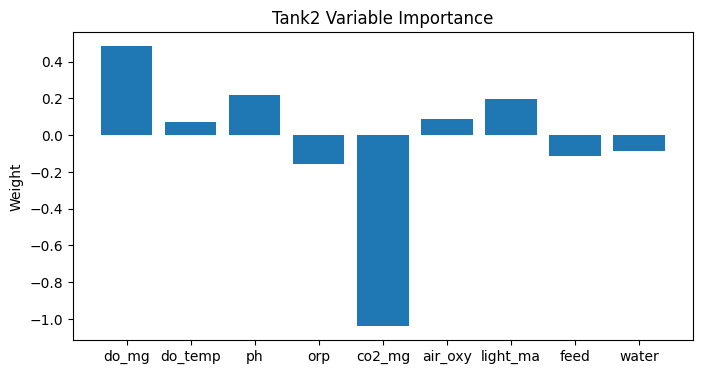

In [13]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(9), weights[:, 0])
ax.set_xticks(range(9))
ax.set_xticklabels(['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed', 'water'])
ax.set_ylabel('Weight')
ax.set_title('Tank2 Variable Importance')
plt.show()

In [ ]:
japonica_validation_features_X

In [ ]:
X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-09-10 20:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 9))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [ ]:
y_date = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-09-10 20:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [ ]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [ ]:
X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-31 20:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [ ]:
y_date = japonica_validation_features_X.loc['2021-07-21 03:00':'2021-07-31 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [ ]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [ ]:
X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-21 20:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [ ]:
y_date = japonica_validation_features_X.loc['2021-07-21 03:00':'2021-07-21 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [ ]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [ ]:
X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-21 11:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [ ]:
y_date = japonica_validation_features_X.loc['2021-07-21 03:00':'2021-07-21 14:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [ ]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [ ]:
japonica_validation_features_X.at['2021-07-21 08:00', 'feed_quantity'] = 6

X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-21 11:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [ ]:
y_date = japonica_validation_features_X.loc['2021-07-21 03:00':'2021-07-21 14:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [ ]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)